In [12]:
import os
import sys
import json
import glob
import random
import shutil
from pathlib import Path

import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from ultralytics import YOLO


In [18]:
print("Current working directory:", os.getcwd())
os.chdir("/Users/lucatognari/Downloads/YOLO_Luca") #metti come directory il path del progetto, all'interno del quale si trova la cartella kvasir-mask

# ========== CONFIGURATION ==========
IMAGE_DIR = "Kvasir-mask/images"          # All 2500 images
MASK_DIR = "Kvasir-mask/masks"            # Masks for 2000 polyps
JSON_PATH = "Kvasir-mask/bounding-boxes.json"  # Bounding boxes
OUTPUT_DIR = "Kvasir-mask/kvasir_yolo_seg_dataset"
MODEL_SIZE = 'm'  # YOLOv11-nano
BATCH_SIZE = 16   # Increase for nano
EPOCHS = 100
IMG_SIZE = 640
DATA_YAML = f"{OUTPUT_DIR}/data.yaml"


Current working directory: /Users/lucatognari/Downloads/YOLO_Luca


In [19]:
import json
from collections import defaultdict

# NOTE: Adjust this path to point to your actual Kvasir annotation JSON file!
JSON_PATH = "Kvasir-mask/bounding-boxes.json" 

def count_polyp_images(json_path):
    """
    Analyzes the JSON annotation file to count single and multi-polyp images, 
    and lists the IDs of images categorized by their exact polyp count.
    """
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Annotation file not found at {json_path}")
        return
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file at {json_path}")
        return

    # Initialize counters and lists
    total_images = len(data)
    polyp_counts = defaultdict(int)
    # New structure to store IDs by their exact polyp count
    polyp_ids_by_count = defaultdict(list) 

    print(f"Analyzing {total_images} image entries...")
    
    # Iterate through each image key in the JSON file
    for image_id, annotation_data in data.items():
        
        num_polyp = 0
        # Check if the annotation contains a list of bounding boxes
        if 'bbox' in annotation_data and isinstance(annotation_data['bbox'], list):
            num_polyp = len(annotation_data['bbox'])
                
        polyp_counts[num_polyp] += 1
        polyp_ids_by_count[num_polyp].append(image_id) # Store the ID under its count

    # --- Summary Printing ---
    print("\n" + "="*40)
    print("Detailed Polyp Count and Image ID Summary")
    print("="*40)

    # Print overall summary
    single_polyp_images = polyp_counts.get(1, 0)
    zero_polyp_images = polyp_counts.get(0, 0)
    multi_polyp_images = sum(count for num, count in polyp_counts.items() if num > 1)

    print(f"Total Images Analyzed: {total_images}")
    print(f"Images with 0 polyp:   {zero_polyp_images}")
    print(f"Images with 1 polyp:   {single_polyp_images}")
    print(f"Images with >1 polyp:  {multi_polyp_images}")
    
    # --- Detailed Breakdown of Multi-Polyp Images ---
    
    # Filter for counts > 1 and sort them for clean printing
    multi_polyp_groups = {k: v for k, v in polyp_ids_by_count.items() if k > 1}

    if multi_polyp_groups:
        print("\n--- Image IDs by Specific Polyp Count (Count > 1) ---")
        
        # Print results in ascending order of polyp count
        for count in sorted(multi_polyp_groups.keys()):
            image_ids = multi_polyp_groups[count]
            print(f"\nImages with {count} polyp(s) ({len(image_ids)} images):")
            # Print the IDs in a list format
            for image_id in image_ids:
                print(f"- {image_id}")
    else:
        print("\nNo images found with multiple polyps.")
    
    print("\n" + "="*40)


# --- EXECUTION ---
if __name__ == "__main__":
    count_polyp_images(JSON_PATH)


Analyzing 1000 image entries...

Detailed Polyp Count and Image ID Summary
Total Images Analyzed: 1000
Images with 0 polyp:   0
Images with 1 polyp:   952
Images with >1 polyp:  48

--- Image IDs by Specific Polyp Count (Count > 1) ---

Images with 2 polyp(s) (41 images):
- 90d30949-a733-4e0e-8fdc-b8687e8548ad
- 3bd30288-3126-4091-8f5b-b459cde5e48a
- 9a8bdb7c-bfa7-4048-a342-4b98d457660c
- 2d8b35e2-06c8-4d23-89dd-b97d1ab9283d
- a810b859-77c8-4d69-b53b-12d61c2eb5e2
- 6345de1a-944e-43e7-8b34-4368d4bc281d
- d2d6e4a5-77e0-4859-9376-e9a80d10839c
- 892221e8-dbca-4abf-bd54-91da857b3c32
- ba1162cf-5c78-46b9-a334-d669f8878b06
- 099b142c-4abb-47e6-be7d-230aa7c19fa1
- 9564fe16-484f-4af2-b61f-22bf6e01fa8c
- fdcde2d9-f531-403f-9bcd-c6256a1e4c78
- 6d54bb62-e9c7-4a21-a98b-b95917dd7827
- 8fc70ff3-f538-49ab-b153-e3315e11c913
- 23c36bb4-f551-48f2-9c69-6aa77be3d5ef
- adc070d1-04c3-46b3-8683-a816effcd13e
- d4b7902e-046e-4739-899c-af440e33be82
- 98d1679d-ff59-4aad-9f69-2e1780de7de6
- 605b01a7-9e3f-4b03-8ac1

PART 1: DATASET CONVERTER (SEGMENTATION WITH NEGATIVE SAMPLES)

In [26]:
class KvasirToYOLOSeg:
    """Convert Kvasir masks + JSON to YOLO segmentation format with healthy images."""
    MIN_AREA = 200  # Minimum area to consider a contour a valid polyp
    MAX_ASPECT_RATIO = 8.0

    def __init__(self, image_dir, mask_dir, json_path, output_dir, seed=42):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.json_path = Path(json_path)
        self.output_dir = Path(output_dir)
        self.seed = seed

        # Load JSON annotations (for polyp images only)
        with open(self.json_path, 'r') as f:
            self.annotations = json.load(f)

        if not isinstance(self.annotations, dict):
            raise ValueError("Annotations JSON must be a dict keyed by image ID.")

    @staticmethod
    def mask_to_polygon(mask):
        

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return None
        
        valid_polygons = []
        
        # Calculate the approximation tolerance (epsilon) based on the perimeter
        epsilon_multiplier = 0.000001

        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            epsilon = epsilon_multiplier * perimeter
            
            # Approximate the contour to simplify the polygon
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Calculate metrics for noise filtering
            area = cv2.contourArea(approx)
            x, y, approx_w, approx_h = cv2.boundingRect(approx)
            
            # Avoid division by zero
            aspect_ratio = approx_w / approx_h if approx_h != 0 else KvasirToYOLOSeg.MAX_ASPECT_RATIO + 1
            
            # 1. Area Check: Filters out contours that are too small (noise)
            if area < KvasirToYOLOSeg.MIN_AREA:
                continue
            
            # 2. Filter out contours that are too thin/elongated (e.g., line artifacts)
            if aspect_ratio > KvasirToYOLOSeg.MAX_ASPECT_RATIO or 1/aspect_ratio > KvasirToYOLOSeg.MAX_ASPECT_RATIO:
                continue
            
            # Append the raw NumPy array coordinates
            valid_polygons.append(approx.reshape(-1, 2))
            
        return valid_polygons if valid_polygons else None


    @staticmethod
    def normalize_polygon(polygon, img_width, img_height):
        """Normalize polygon coordinates to [0, 1]."""
        polygon = polygon.astype(float)
        polygon[:, 0] /= img_width
        polygon[:, 1] /= img_height
        
        # Clamp to valid range
        polygon = np.clip(polygon, 0.0, 1.0)
        return polygon
    
    # NOTE: _voc_to_yolo_bbox is included but NO LONGER CALLED in _process_split
    @staticmethod
    def _voc_to_yolo_bbox(bbox, img_width, img_height):
        """Convert Pascal VOC bbox to YOLO format with validation."""
        xmin = float(bbox['xmin'])
        ymin = float(bbox['ymin'])
        xmax = float(bbox['xmax'])
        ymax = float(bbox['ymax'])

        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0
        width = xmax - xmin
        height = ymax - ymin

        x_center /= img_width
        y_center /= img_height
        width /= img_width
        height /= img_height

        return [0, x_center, y_center, width, height]

    def prepare_dataset(self, train_split=0.7, val_split=0.2, test_split=0.1):
        """Prepare segmentation dataset with polyp + healthy images."""
        
        if abs(train_split + val_split + test_split - 1.0) > 1e-8:
            raise ValueError(f"Splits must sum to 1.0, got {train_split + val_split + test_split}")

        # Create directories
        for split in ['train', 'val', 'test']:
            (self.output_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
            (self.output_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)

        # Get all images
        all_images = list(self.image_dir.glob('*.jpg')) + list(self.image_dir.glob('*.png'))
        
        # Separate polyp vs healthy images
        polyp_images = [img for img in all_images if img.stem in self.annotations]
        healthy_images = [img for img in all_images if img.stem not in self.annotations]

        # ... (splitting and shuffling logic remains unchanged) ...
        # (omitted for brevity, assume splitting is correct)

        # Split each category proportionally
        def split_list(lst, train_r, val_r):
            n = len(lst)
            n_train = int(n * train_r)
            n_val = int(n * val_r)
            return lst[:n_train], lst[n_train:n_train + n_val], lst[n_train + n_val:]

        polyp_train, polyp_val, polyp_test = split_list(polyp_images, train_split, val_split)
        healthy_train, healthy_val, healthy_test = split_list(healthy_images, train_split, val_split)

        splits = {
            'train': polyp_train + healthy_train,
            'val': polyp_val + healthy_val,
            'test': polyp_test + healthy_test
        }

        rnd = random.Random(self.seed)
        for split_imgs in splits.values():
            rnd.shuffle(split_imgs)

        print(f"\n{'='*70}")
        print("DATASET SPLIT")
        # ... (split summary printing remains unchanged) ...
        print(f"Train: {len(splits['train'])} ({len(polyp_train)} polyps + {len(healthy_train)} healthy)")
        print(f"Val:   {len(splits['val'])} ({len(polyp_val)} polyps + {len(healthy_val)} healthy)")
        print(f"Test:  {len(splits['test'])} ({len(polyp_test)} polyps + {len(healthy_test)} healthy)")
        print(f"{'='*70}\n")


        # Process each split
        for split_name, images in splits.items():
            print(f"Processing {split_name} split ({len(images)} images)...")
            self._process_split(images, split_name)

        # Create YAML
        self._create_yaml()

        print(f"\n✓ Segmentation dataset created!")
        print(f"  Output: {self.output_dir.resolve()}")


    def _process_split(self, image_files, split_name):
        img_dir = self.output_dir / 'images' / split_name
        label_dir = self.output_dir / 'labels' / split_name

        for img_path in image_files:
            img_id = img_path.stem

            # Load image and copy to output directory
            img = cv2.imread(str(img_path))
            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue
            h, w = img.shape[:2]
            shutil.copy(img_path, img_dir / img_path.name)

            label_path = label_dir / f"{img_id}.txt"

            if img_id in self.annotations:
                # Polyp image processing
                
                # Load and prepare mask
                mask_path = self.mask_dir / f"{img_id}.jpg"
                if not mask_path.exists():
                    mask_path = self.mask_dir / f"{img_id}.png"

                if not mask_path.exists():
                    print(f"Warning: Mask not found for {img_id}")
                    label_path.touch()
                    continue

                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"Warning: Could not read mask for {img_id}")
                    label_path.touch()
                    continue

                if mask.shape[:2] != (h, w):
                    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

                _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

                # Get the SINGLE clean polygon (from the mask_to_polygon logic)
                polygons = self.mask_to_polygon(mask)

                with open(label_path, 'w') as f:
                    # Write segmentation polygon(s)
                    if polygons:
                        for polygon in polygons:
                            norm_poly = self.normalize_polygon(polygon, w, h)
                            # Format for YOLO: class_id x1 y1 x2 y2 ...
                            coords = ' '.join(f"{x:.6f} {y:.6f}" for x, y in norm_poly)
                            f.write(f"0 {coords}\n")
                    else:
                        print(f"Warning: No valid polygons for {img_id}")

                # !!! CRITICAL FIX: The section that wrote the original BBOX line (0 x y w h) 
                # has been removed to prevent the redundant second bounding box in the label file.

            else:
                # Healthy image — create empty label file
                label_path.touch()
                
    def _create_yaml(self):
        """Create data.yaml for segmentation."""
        data = {
            'path': str(self.output_dir.resolve()),
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': 1,
            'names': ['polyp']
        }

        yaml_path = self.output_dir / 'data.yaml'
        # NOTE: Assumes 'yaml' library is available
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)
        print(f"\n  Created: {yaml_path}")

In [21]:
import cv2
import json
from pathlib import Path
import numpy as np
from collections import defaultdict
import os

# NOTE: You must import your class here! 
# This assumes your main data preparation class is KvasirToYOLOSeg
# and is available in a file named data_prep.py or similar.

# --- CONFIGURATION (Adjust these paths!) ---
IMAGE_DIR = Path("Kvasir-mask/images") 
MASK_DIR = Path("Kvasir-mask/masks") 
JSON_PATH = Path("Kvasir-mask/bounding-boxes.json")

# Dummy output path required for KvasirToYOLOSeg initialization
DUMMY_OUTPUT_DIR = Path("temp_verification_output") 

def get_expected_counts(json_path):
    """Loads the JSON and returns a dictionary of image_id: expected_polyp_count."""
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON: {e}")
        return {}

    expected_counts = {}
    for img_id, annotation_data in data.items():
        num_bbox = 0
        if 'bbox' in annotation_data and isinstance(annotation_data['bbox'], list):
            num_bbox = len(annotation_data['bbox'])
        if num_bbox > 0:
             # Only include images with at least one polyp
            expected_counts[img_id] = num_bbox
            
    return expected_counts

def run_full_verification(ConverterClass):
    """
    Compares the expected polyp count from JSON bounding boxes with the actual 
    polygons detected by the ConverterClass's mask_to_polygon method.
    """
    print("="*70)
    print("FULL DATASET POLYGON DETECTION VERIFICATION")
    print("="*70)
    
    # 1. Get all expected counts from JSON
    expected_counts = get_expected_counts(JSON_PATH)
    if not expected_counts:
        print("No polyp annotations found or JSON failed to load. Exiting.")
        return

    total_polyp_images = len(expected_counts)
    mismatch_counts = defaultdict(list)
    total_mismatches = 0
    
    # Initialize the converter class (need to import it first!)
    # Note: Since the KvasirToYOLOSeg class is not in this file, you must 
    # ensure it is imported correctly before running this script.
    try:
        converter = ConverterClass(IMAGE_DIR, MASK_DIR, JSON_PATH, DUMMY_OUTPUT_DIR)
    except NameError:
        print("CRITICAL ERROR: KvasirToYOLOSeg class is not defined or imported.")
        print("Please ensure 'from data_prep import KvasirToYOLOSeg' is uncommented and correct.")
        return
    except Exception as e:
        print(f"Error initializing converter: {e}")
        return

    
    print(f"Starting check on {total_polyp_images} images with polyps...")

    for i, (img_id, expected_count) in enumerate(expected_counts.items()):
        
        # Determine the mask path
        mask_path = MASK_DIR / f"{img_id}.jpg"
        if not mask_path.exists():
            mask_path = MASK_DIR / f"{img_id}.png"

        if not mask_path.exists():
            print(f"[{i+1}/{total_polyp_images}] WARNING: Mask file not found for {img_id}")
            continue

        # Load and preprocess mask
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[{i+1}/{total_polyp_images}] ERROR: Could not read mask for {img_id}")
            continue

        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # 2. Get actual detected polygon count
        polygons = converter.mask_to_polygon(mask)
        detected_count = len(polygons) if polygons else 0
        
        # 3. Compare and record discrepancies
        if detected_count != expected_count:
            total_mismatches += 1
            mismatch_type = f"Expected {expected_count} vs Detected {detected_count}"
            mismatch_counts[mismatch_type].append(img_id)
            print(f"[{i+1}/{total_polyp_images}] MISMATCH for {img_id}: Expected {expected_count}, Detected {detected_count}")
        # else:
        #     print(f"[{i+1}/{total_polyp_images}] Match: {img_id} ({expected_count})") # Uncomment for full logging

    # --- Summary Report ---
    print("\n" + "="*70)
    print("VERIFICATION SUMMARY")
    print("="*70)
    print(f"Total Polyp Images Checked: {total_polyp_images}")
    print(f"Total Mismatches Found: {total_mismatches}")
    print(f"Total Matches Found: {total_polyp_images - total_mismatches}")
    
    if total_mismatches > 0:
        print("\n--- DETAILED MISMATCH REPORT ---")
        for mismatch_type, ids in mismatch_counts.items():
            print(f"\n{mismatch_type} ({len(ids)} images):")
            for img_id in ids:
                print(f"- {img_id}")
    else:
        print("\n**SUCCESS: All detected polygon counts match the expected JSON bounding box counts!**")

# --- EXECUTION ---
if __name__ == "__main__":
    # Note: In a Jupyter Notebook, the KvasirToYOLOSeg class should be defined in a previous cell.
    # The file-based import is commented out here for notebook compatibility.
    # from data_prep import KvasirToYOLOSeg
    run_full_verification(KvasirToYOLOSeg)


FULL DATASET POLYGON DETECTION VERIFICATION
Starting check on 1000 images with polyps...

VERIFICATION SUMMARY
Total Polyp Images Checked: 1000
Total Mismatches Found: 0
Total Matches Found: 1000

**SUCCESS: All detected polygon counts match the expected JSON bounding box counts!**


Starting visualization for problematic IDs...
Total IDs to check: 8



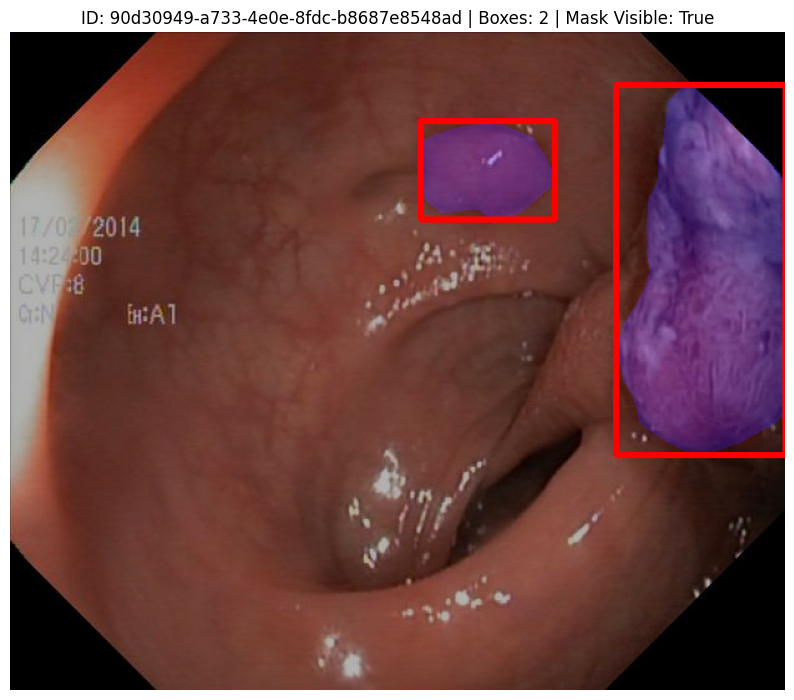

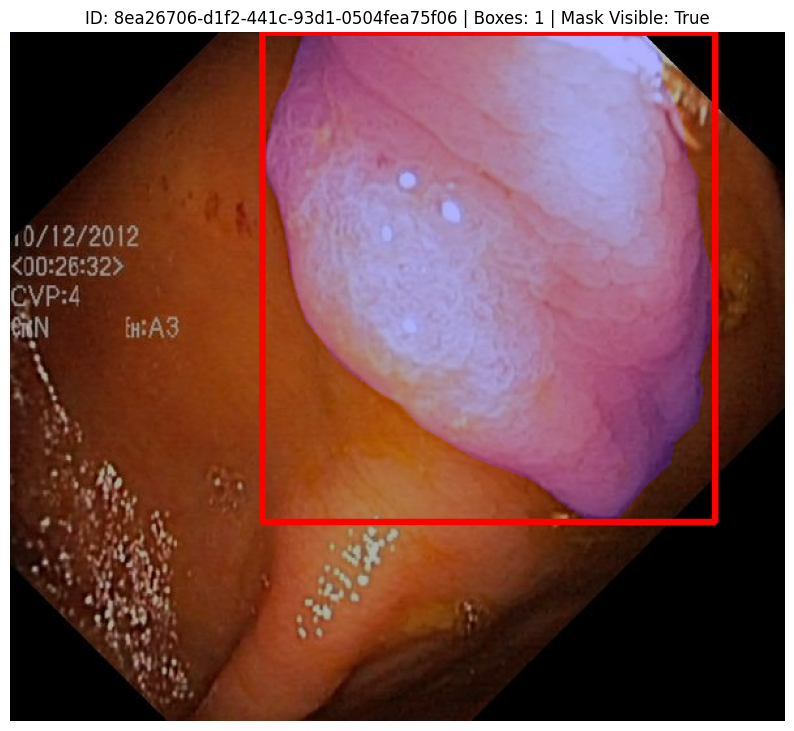

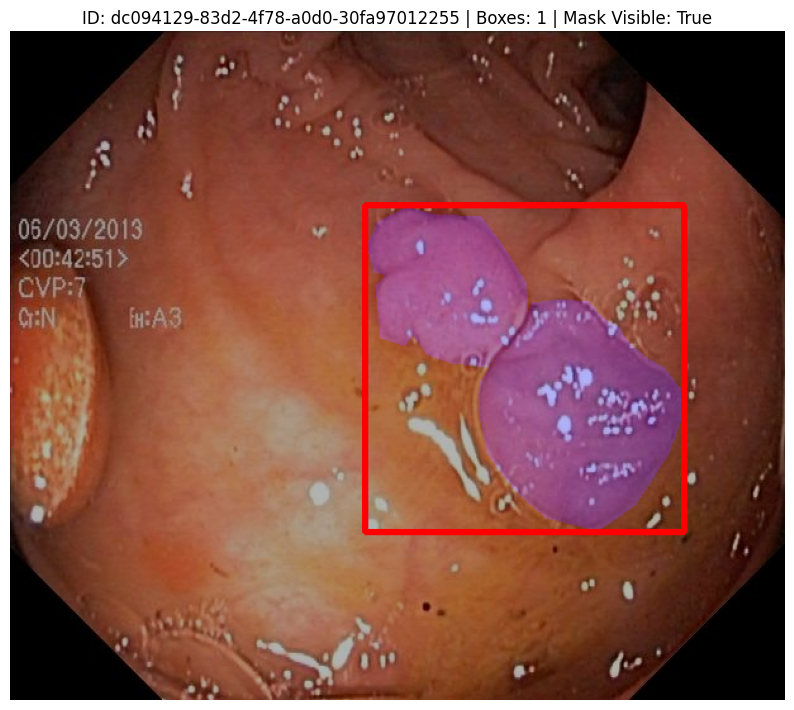

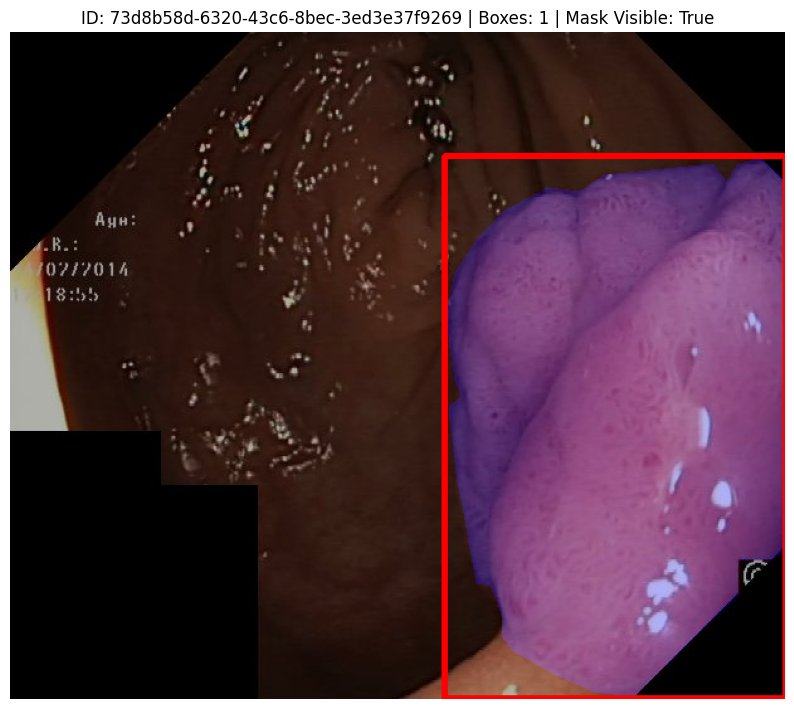

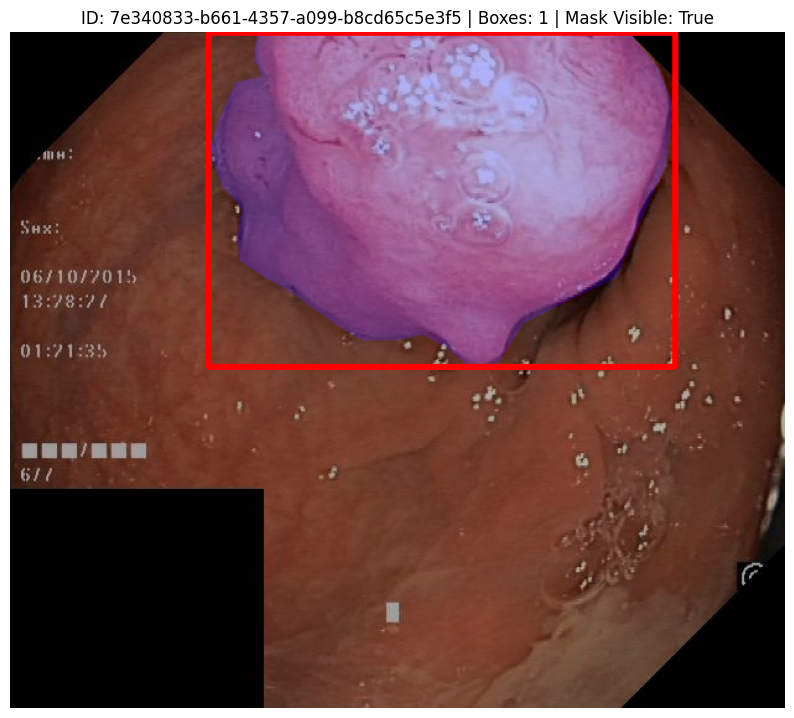

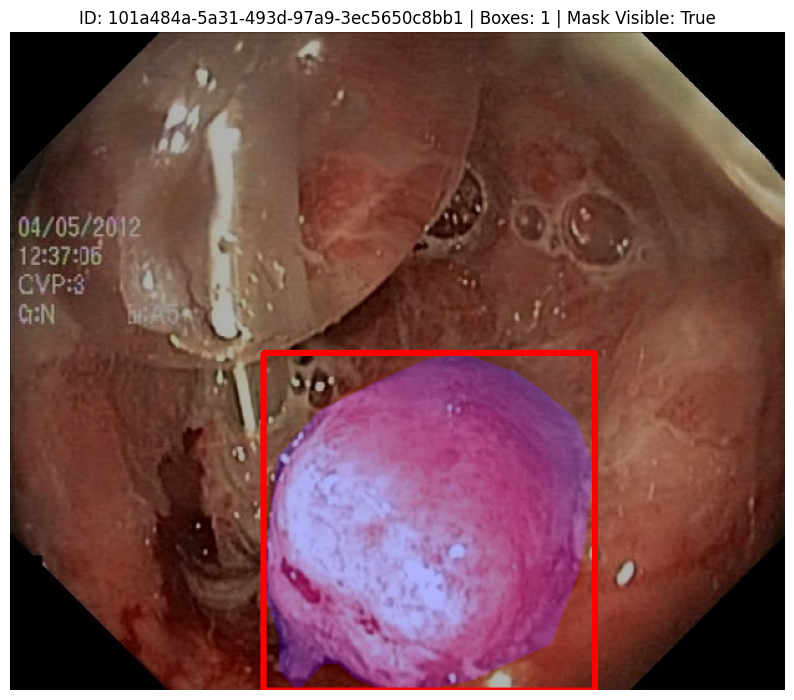

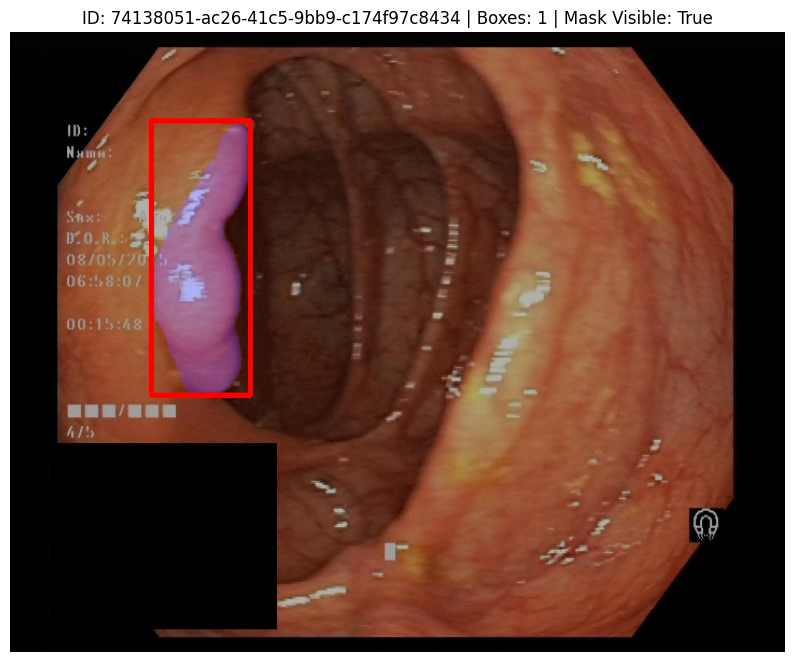

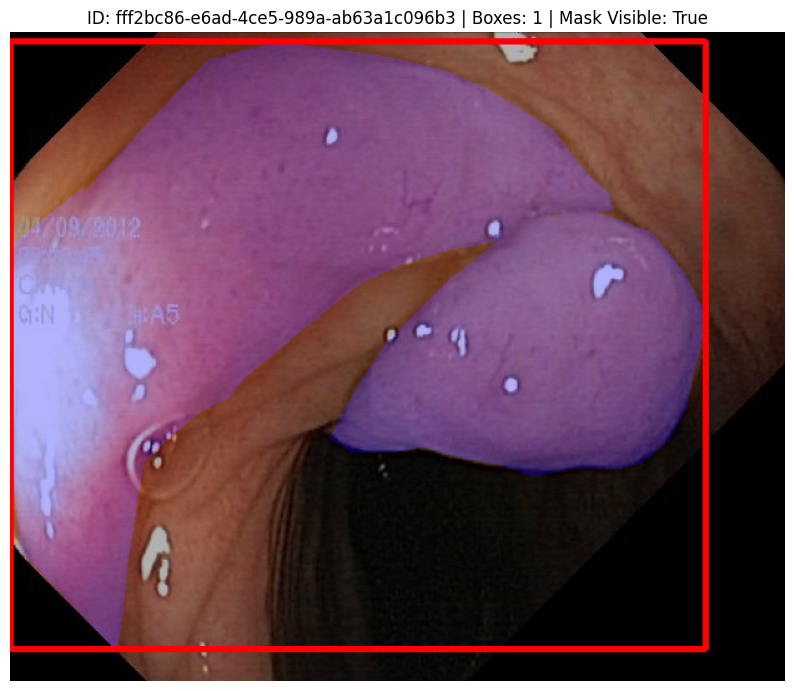


Visualization complete. Review plots to confirm mask-box discrepancy.


In [22]:

# List of image IDs showing a mismatch (Expected > Detected)
PROBLEM_IDS = [
    '90d30949-a733-4e0e-8fdc-b8687e8548ad', # Expected 3, Detected 2
    '8ea26706-d1f2-441c-93d1-0504fea75f06', # Expected 2, Detected 1
    'dc094129-83d2-4f78-a0d0-30fa97012255', # Expected 2, Detected 1
    '73d8b58d-6320-43c6-8bec-3ed3e37f9269', # Expected 2, Detected 1
    '7e340833-b661-4357-a099-b8cd65c5e3f5', # Expected 2, Detected 1
    '101a484a-5a31-493d-97a9-3ec5650c8bb1', # Expected 2, Detected 1
    '74138051-ac26-41c5-9bb9-c174f97c8434', # Expected 2, Detected 1
    'fff2bc86-e6ad-4ce5-989a-ab63a1c096b3'  # Expected 2, Detected 1
]

def visualize_annotations(image_id):
    """
    Loads and visualizes the image, mask, and JSON bounding boxes for a single ID.
    """
    img_path = Path(IMAGE_DIR) / f"{image_id}.jpg"
    mask_path = Path(MASK_DIR) / f"{image_id}.jpg"
    
    if not img_path.exists():
        img_path = Path(IMAGE_DIR) / f"{image_id}.png"
    if not mask_path.exists():
        mask_path = Path(MASK_DIR) / f"{image_id}.png"

    if not img_path.exists():
        print(f"Image not found for ID: {image_id}")
        return

    # Load data
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    with open(JSON_PATH, 'r') as f:
        annotations = json.load(f)
    
    # --- CRITICAL FIX: Access the nested 'bbox' list based on the user's JSON structure ---
    image_data = annotations.get(image_id)
    if image_data is None:
        print(f"Warning: No annotation entry found for ID: {image_id}")
        return
        
    boxes = image_data.get('bbox', [])
    # -------------------------------------------------------------------------------------

    if img is None: return
    
    # 1. Overlay Mask on Image
    
    # Resize mask if necessary (Kvasir masks are often 512x512)
    if mask is not None and mask.shape[:2] != img.shape[:2]:
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert mask to 3 channels for overlay and set transparency
    mask_color = np.zeros_like(img, dtype=np.uint8)
    mask_color[mask > 127] = [0, 0, 255] # Blue color for mask
    
    # Blend the mask and image
    blended_img = cv2.addWeighted(img, 0.7, mask_color, 0.3, 0)
    
    # 2. Draw Bounding Boxes
    for box_data in boxes:
        # box_data is now expected to be a dictionary like {'label': 'polyp', 'xmin': ..., 'ymin': ...}
        
        # Skip any malformed entries that aren't dictionaries
        if not isinstance(box_data, dict):
            print(f"Skipping non-dictionary box data for {image_id}.")
            continue
            
        # Ensure coordinates are present before accessing
        if not all(k in box_data for k in ['xmin', 'ymin', 'xmax', 'ymax']):
            print(f"Skipping box data for {image_id}: Missing coordinate keys.")
            continue
            
        xmin = int(box_data['xmin'])
        ymin = int(box_data['ymin'])
        xmax = int(box_data['xmax'])
        ymax = int(box_data['ymax'])
        
        # Draw red bounding box (thickness 3)
        cv2.rectangle(blended_img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)

    # 3. Plotting
    plt.figure(figsize=(10, 10))
    plt.imshow(blended_img)
    plt.title(f"ID: {image_id} | Boxes: {len(boxes)} | Mask Visible: {np.sum(mask>0) > 0}")
    plt.axis('off')
    plt.show()

print("Starting visualization for problematic IDs...")
print(f"Total IDs to check: {len(PROBLEM_IDS)}\n")

for pid in PROBLEM_IDS:
    visualize_annotations(pid)

print("\nVisualization complete. Review plots to confirm mask-box discrepancy.")


PART 2: TRAINING FUNCTION (YOLOv11-seg)

In [35]:
def train_yolo_seg(data_yaml_path, model_size=MODEL_SIZE, epochs=100, img_size=640, 
                   batch_size=BATCH_SIZE, workers=4, lr0=1e-4):
    """Train YOLOv11 Segmentation model."""
    
    # Device detection
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
        print("Using Apple Silicon GPU (MPS)")
    elif torch.cuda.is_available():
        device = 0
        print("Using NVIDIA GPU (CUDA)")
    else:
        device = 'cpu'
        print("Using CPU")

    # Load YOLOv11-seg model
    model = YOLO(f'yolo11{model_size}-seg.pt')  # YOLOv11 segmentation

    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        name='polyp_segmentation_v11',
        patience=30,
        save=True,
        device=device,
        workers=workers,
        optimizer='AdamW',
        project='Kvasir-mask',
        
        # Learning rate settings
        lr0=lr0,
        lrf=0.01,
        cos_lr=True,
        warmup_epochs=5,
        warmup_momentum=0.8,
        momentum=0.937,
        weight_decay=0.001,
        dropout=0.1,
        
        # Multi-scale training
        multi_scale=True,
        
        # Medical imaging augmentations
        mosaic=0.0,          # Disabled for medical
        mixup=0.0,           # Light mixup
        copy_paste=0.0,      # Copy-paste augmentation
        erasing=0.1,         # Random erasing
        hsv_h=0.01,          # Minimal hue (preserve color)
        hsv_s=0.2,
        hsv_v=0.2,
        degrees=5.0,
        translate=0.05,
        scale=0.1,
        flipud=0.5,
        fliplr=0.5,
        shear=1.0,
        perspective=0.0001,
        
        # Advanced augmentations
        augment=True,
        auto_augment='randaugment',
        
        # Segmentation specific
        mask_ratio=4,
        overlap_mask=True
    )
    
    return model


PART 3: EVALUATION & INFERENCE

In [23]:
def evaluate_model_seg(model_path, data_yaml_path, split='val', conf = 0.001, iou = 0.5):
    """Evaluate segmentation model."""
    model = YOLO(model_path)
    
    print(f"Running validation with NMS IOU = {iou} and Conf = {conf}")
    metrics = model.val(
        data=data_yaml_path, 
        split=split,
        conf=conf,
        iou=iou
    )

    print(f"\n{'='*70}")
    print(f"EVALUATION RESULTS ON {split.upper()} SET")
    print(f"{'='*70}")
    
    # Box metrics
    print(f"Box mAP@0.50     : {metrics.box.map50:.4f}")
    print(f"Box mAP@0.50-95  : {metrics.box.map:.4f}")
    
    # Mask metrics (segmentation)
    print(f"\nMask mAP@0.50    : {metrics.seg.map50:.4f}")
    print(f"Mask mAP@0.50-95 : {metrics.seg.map:.4f}")
    
    if hasattr(metrics.box, 'p') and len(metrics.box.p) > 0:
        print(f"\nBox Precision    : {metrics.box.p[0]:.4f}")
    if hasattr(metrics.box, 'r') and len(metrics.box.r) > 0:
        print(f"Box Recall       : {metrics.box.r[0]:.4f}")
    
    if hasattr(metrics.seg, 'p') and len(metrics.seg.p) > 0:
        print(f"\nMask Precision   : {metrics.seg.p[0]:.4f}")
    if hasattr(metrics.seg, 'r') and len(metrics.seg.r) > 0:
        print(f"Mask Recall      : {metrics.seg.r[0]:.4f}")
    
    print(f"{'='*70}\n")

    return metrics


def predict_and_visualize_seg(model_path, image_path, conf_threshold=0.25, iou = 0.5):
    """Run inference and visualize segmentation results on a single image."""
    model = YOLO(model_path)
    results = model(image_path, conf=conf_threshold, iou=iou)

    for result in results:
        # Plot with both boxes and masks
        img_with_results = result.plot()
        
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_with_results, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Polyp Segmentation (confidence > {conf_threshold})', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Print detections
        if hasattr(result, 'boxes') and len(result.boxes) > 0:
            print(f"\n✓ Detected {len(result.boxes)} polyp(s):")
            for i, box in enumerate(result.boxes):
                conf = float(box.conf[0].item())
                print(f"  Polyp {i+1}: confidence = {conf:.3f}")
        else:
            print("\n✓ No polyps detected (healthy image)")


def predict_on_all_images_seg(model_path, image_dir, data_yaml_path=None, 
                               conf_threshold=0.25, save_dir='predictions_seg', iou = 0.5):
    """
    Run inference on ALL images in a directory, save results, and compute statistics.
    Works with segmentation models - saves images with boxes + masks.
    
    Args:
        model_path: Path to trained segmentation model
        image_dir: Directory with test or val images
        data_yaml_path: Optional path to data.yaml for mAP evaluation
        conf_threshold: Confidence threshold
        save_dir: Directory to save prediction images
    """
    model = YOLO(model_path)
    image_dir = Path(image_dir)
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    label_dir = image_dir.parent.parent / 'labels' / image_dir.name
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if not image_files:
        print(f"No images found in {image_dir}")
        return

    print(f"\n{'='*70}")
    print(f"RUNNING INFERENCE ON ALL {len(image_files)} IMAGES")
    print(f"{'='*70}\n")

    total_gt_polyps = 0
    total_pred_polyps = 0
    images_with_polyps = 0

    TP = FP = FN = TN = 0

    for img_path in image_files:
        # Check ground truth
        label_path = label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                gt_boxes = [line for line in f if line.strip()]
                num_gt = len(gt_boxes)
        else:
            num_gt = 0

        # Run inference
        results = model(str(img_path), conf=conf_threshold, iou=iou, verbose=False)

        for result in results:
            # Save image with boxes AND masks
            img_with_results = result.plot()
            output_path = save_dir / f"pred_{img_path.name}"
            cv2.imwrite(str(output_path), img_with_results)

            # Count predictions
            if hasattr(result, 'boxes') and len(result.boxes) > 0:
                num_pred = len(result.boxes)
                total_pred_polyps += num_pred
                images_with_polyps += 1
                print(f"✓ {img_path.name}: {num_pred} polyp(s)")
            else:
                num_pred = 0
                print(f"  {img_path.name}: No polyps detected")

            # Contingency matrix (image-level)
            if num_gt > 0 and num_pred > 0:
                TP += 1
            elif num_gt == 0 and num_pred > 0:
                FP += 1
            elif num_gt > 0 and num_pred == 0:
                FN += 1
            elif num_gt == 0 and num_pred == 0:
                TN += 1

            total_gt_polyps += num_gt

    # Compute metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # mAP evaluation (uses YOLO's built-in validation)
    map50_box = map5095_box = None
    map50_mask = map5095_mask = None
    
    if data_yaml_path:
        try:
            metrics = model.val(
                data=data_yaml_path, 
                split=image_dir.name, 
                conf=conf_threshold, 
                iou=iou,
                verbose=False
            )
            
            # Box metrics
            map50_box = float(getattr(metrics.box, 'map50', 0.0))
            map5095_box = float(getattr(metrics.box, 'map', 0.0))
            
            # Mask metrics (segmentation specific)
            if hasattr(metrics, 'seg'):
                map50_mask = float(getattr(metrics.seg, 'map50', 0.0))
                map5095_mask = float(getattr(metrics.seg, 'map', 0.0))
        except Exception as e:
            print(f"\nWarning: Could not compute mAP metrics: {e}")

    # Summary
    print(f"\n{'='*70}")
    print(f"INFERENCE SUMMARY")
    print(f"{'='*70}")
    print(f"Total images:              {len(image_files)}")
    print(f"Images with polyps:        {images_with_polyps}")
    print(f"Images without polyps:     {len(image_files) - images_with_polyps}")
    print(f"Total ground truth polyps: {total_gt_polyps}")
    print(f"Total predicted polyps:    {total_pred_polyps}")
    
    print(f"\nContingency Matrix (image-level):")
    print(f"  TP (GT & Pred):           {TP}")
    print(f"  FP (No GT, Pred):         {FP}")
    print(f"  FN (GT, No Pred):         {FN}")
    print(f"  TN (No GT, No Pred):      {TN}")
    
    print(f"\nImage-Level Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1_score:.4f}")
    
    if map50_box is not None:
        print(f"\nBox Detection Metrics:")
        print(f"  mAP@0.50:     {map50_box:.4f}")
        print(f"  mAP@0.50-0.95: {map5095_box:.4f}")
    
    if map50_mask is not None:
        print(f"\nMask Segmentation Metrics:")
        print(f"  mAP@0.50:     {map50_mask:.4f}")
        print(f"  mAP@0.50-0.95: {map5095_mask:.4f}")
    
    print(f"\nPredictions saved to: {save_dir.resolve()}")
    print(f"{'='*70}")


Run the model!!

In [24]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# ========== STEP 1: Dataset Preparation ==========
print("\n" + "="*70)
print("STEP 1: DATASET PREPARATION (SEGMENTATION)")
print("="*70)

converter = KvasirToYOLOSeg(IMAGE_DIR, MASK_DIR, JSON_PATH, OUTPUT_DIR, seed=SEED)
converter.prepare_dataset(train_split=0.7, val_split=0.2, test_split=0.1)




STEP 1: DATASET PREPARATION (SEGMENTATION)

DATASET SPLIT
Train: 1050 (700 polyps + 350 healthy)
Val:   300 (200 polyps + 100 healthy)
Test:  150 (100 polyps + 50 healthy)

Processing train split (1050 images)...
Processing val split (300 images)...
Processing test split (150 images)...

  Created: Kvasir-mask/kvasir_yolo_seg_dataset/data.yaml

✓ Segmentation dataset created!
  Output: /Users/lucatognari/Downloads/YOLO_Luca/Kvasir-mask/kvasir_yolo_seg_dataset


In [ ]:
model = YOLO(f'yolo11{MODEL_SIZE}-seg.pt')  # Replace with your model path if different

search_space = {
    "lr0": (1e-5, 1e-3),
    "lrf": (0.01, 0.1),
    "momentum": (0.6, 0.98),
    "weight_decay": (0.0, 0.001),
    "dfl": (1.0, 2.0),
    "hsv_h": (0.0, 0.02),
    "hsv_s": (0.0, 0.3),
    "hsv_v": (0.0, 0.3),
    "degrees": (0.0, 10.0),
    "translate": (0.0, 0.1),
    "scale": (0.0, 0.2),
    "shear": (0.0, 2.0),
    "perspective": (0.0, 0.0001),
    "flipud": (0.0, 1.0),
    "fliplr": (0.0, 1.0),
    "box": (3.0, 7.5),     # Box loss weight
    "cls": (0.2, 2.0) 
}

model.tune(
    data="Kvasir-mask/kvasir_yolo_seg_dataset/data.yaml",
    epochs=10,
    iterations=100,
    optimizer="AdamW",
    space=search_space,
    plots=True,
    save=True,
    val=True,
    project="Kvasir-mask/tune"  # ✅ Saves results in ./Kvasir_mask/tune/
)

In [ ]:
def find_best_hyperparameters():
    """Search for best_hyperparameters.yaml in tune directory."""
    tune_dir = Path("Kvasir-mask/tune")
    
    if not tune_dir.exists():
        return None
    
    # Search recursively for the file
    for yaml_file in tune_dir.rglob("best_hyperparameters.yaml"):
        print(f"Found hyperparameters at: {yaml_file}")
        return yaml_file
    
    return None


def train_yolo_seg_with_tuned_params(data_yaml_path, best_hyperparameters, 
                                      model_size=MODEL_SIZE, epochs=100, img_size=640, 
                                      batch_size=BATCH_SIZE, workers=4):
    """Train with tuned hyperparameters."""
    
    # Device detection
    if torch.cuda.is_available():
        device = 0
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'

    model = YOLO(f'yolo11{model_size}-seg.pt')

    # ✅ Merge your fixed settings with tuned parameters
    training_args = {
        'data': data_yaml_path,
        'epochs': epochs,
        'imgsz': img_size,
        'batch': batch_size,
        'name': 'polyp_segmentation_v11_tuned',
        'patience': 30,
        'save': True,
        'device': device,
        'workers': workers,
        'optimizer': 'AdamW',
        'project': 'Kvasir-mask',
        
        # Fixed settings (always use these)
        'multi_scale': True,
        'mosaic': 0.0,
        'mixup': 0.0,
        'copy_paste': 0.0,
        'augment': True,
        'auto_augment': 'randaugment',
        'mask_ratio': 4,
        'overlap_mask': True,
        
        # ✅ Add tuned hyperparameters (these override defaults)
        **best_hyperparameters  # This unpacks the dictionary
    }

    results = model.train(**training_args)
    return model

In [ ]:
# ========== STEP 2: Train YOLOv11-seg ==========
print("\n" + "="*70)
print("STEP 2: TRAINING YOLOv11-seg MODEL")
print("="*70)

tuned_params_path = find_best_hyperparameters()

if tuned_params_path and tuned_params_path.exists():
    print(f"\n✓ Found tuned hyperparameters at: {tuned_params_path}")
    
    with open(tuned_params_path, 'r') as f:
        best_hyperparameters = yaml.safe_load(f)
    
    print("\n📋 Loaded Hyperparameters:")
    for key, value in best_hyperparameters.items():
        print(f"  {key}: {value}")
    
    # Train with tuned parameters
    model = train_yolo_seg_with_tuned_params(
        data_yaml_path=DATA_YAML,
        best_hyperparameters=best_hyperparameters,
        model_size=MODEL_SIZE,
        epochs=EPOCHS,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    BEST_MODEL_PATH = Path("Kvasir-mask/polyp_segmentation_v11_tuned/weights/best.pt")
else:
    print("\n⚠️  No tuned parameters found, using defaults...")
    model = train_yolo_seg(
        data_yaml_path=DATA_YAML,
        model_size=MODEL_SIZE,
        epochs=EPOCHS,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        lr0=1e-4  # Good starting point for nano
    )
    BEST_MODEL_PATH = Path("Kvasir-mask/polyp_segmentation_v11/weights/best.pt")

print(f"\n✓ Using model: {BEST_MODEL_PATH}")


In [ ]:
BEST_MODEL_PATH = Path("Kvasir-mask/polyp_segmentation_v11_tuned/weights/best.pt")

# ========== STEP 3: Evaluate Model ==========
print("\n" + "="*70)
print("STEP 3: MODEL EVALUATION")
print("="*70)

evaluate_model_seg(BEST_MODEL_PATH, DATA_YAML, split='test', conf=0.001, iou=0.5) 
# ========== STEP 4A: Quick Visual Test ==========
print("\n" + "="*70)
print("STEP 4A: QUICK VISUAL TEST (Single Image)")
print("="*70)

test_images = list(Path(f"{OUTPUT_DIR}/images/test").glob("*.*"))
if test_images:
    polyp_img = random.choice([img for img in test_images[:10]])
    print(f"\nTesting on: {polyp_img.name}")
    predict_and_visualize_seg(BEST_MODEL_PATH, str(polyp_img), conf_threshold=0.25) 

# ========== STEP 4B: Full Test Set Evaluation ==========
print("\n" + "="*70)
print("STEP 4B: RUNNING INFERENCE ON ALL TEST IMAGES")
print("="*70)

predict_on_all_images_seg(
    BEST_MODEL_PATH, 
    f"{OUTPUT_DIR}/images/test",
    data_yaml_path=DATA_YAML,
    conf_threshold=0.25,
    iou=0.5,#increase to be more lax
    save_dir='test_predictions_seg'
)
print("\n" + "="*70)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)
    